Subject: New Indian Resturant
Vikram Kant

Introduction

This project explores the best location for a new Indian restaurant in the city of New York. The need to find and enjoy Indian cuisine is on the rise. Americans’ increase in travel and a generation of young chefs eager to showcase their heritage. This increased American appetite for more authentic flavors of Indian food coincides perfectly with a new generation of Indian chefs who want to do more. The validation of Michelin stars and Beard nominations has brought a new generation of diners into Indian restaurants. Even high-end foodies are opening their minds to Indian food and helping to spread its appeal. Indian foods offer much of what the evolving American palate craves, including fresh fruits and vegetables, legumes, bold flavors and whole milk dairy products. With Americans snacking more than ever and looking for fresh alternatives to packaged products, as well as open to exploring global flavors, we believe our products and brand have an opportunity to take Indian food mainstream. This report explores which neighborhoods and boroughs of New York City have the most as well as the best Indian restaurants, additionally “Where should we open an Amazing Indian Restaurant?” .

Data:

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required. New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

Methodology:

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe. • FourSquare be used to locate all venues and then filtered by Indian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe. • Data will be sorted based on rankings • Finally, the data be will be visually assessed using graphing from various Python libraries.

Problem Statement:

#What is / are the best location(s) for Indian cuisine in New York City?

#In what Neighborhood and/or borough should I open an Indian restaurant to have the best chance of being successful?

#Where would I go in New York City to have the best Indian food?

Importing required libararies

In [292]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Define function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [293]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define function to communicate with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return venue id , venue name and category.

In [314]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID ='ES3ZXR1ALGY0Q0YQVMG0RUMAO00WTUNG4K1C2JN5C2J0O1AZ' # your Foursquare ID
    CLIENT_SECRET ='H3VNVPRCUTEX4NP23B4ANBLXWZKKIZ0VM4NKN0IQRYPYXPTW' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Defining function to get venue details like like count , rating , tip counts for a given venue id. This will be used for further analysis and ranking.

In [312]:

def get_venue_details(venue_id):
        
    CLIENT_ID = 'CLIENT_ID' # your Foursquare ID
    CLIENT_SECRET = 'CLIENT_SECRET' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

defining funtion to get New york city data " Boroughs, Neighborhoods along with their latitude and longitude".

In [308]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [309]:

# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [243]:
new_york_data.shape

(306, 4)

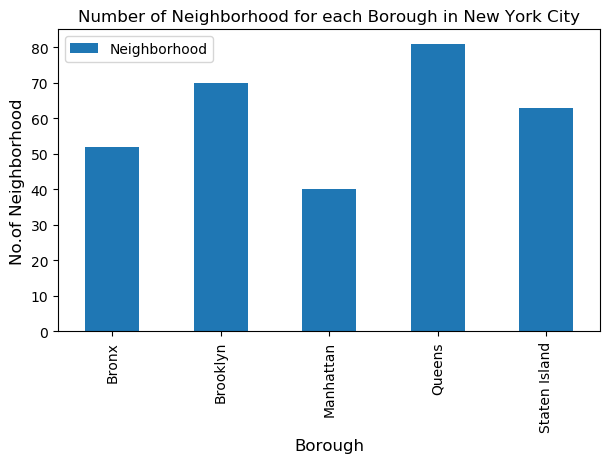

In [244]:
plt.figure(figsize=(7,4), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 12)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=12)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Collect Indian resturants for each Neighborhood, We can see that Queens has highest number of neighborhoods among all Boroughs

In [319]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

KeyError: 'groups'

In [204]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


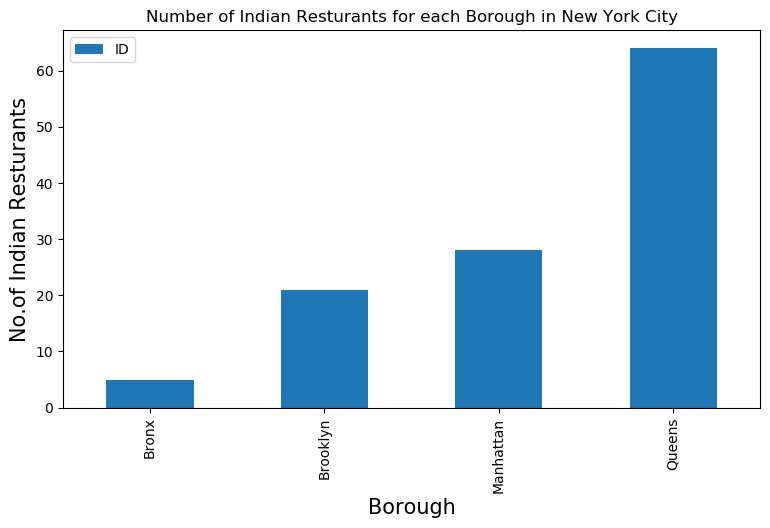

In [205]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

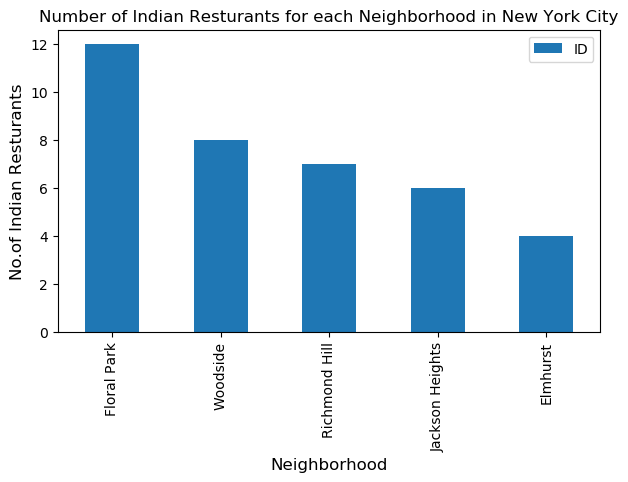

In [148]:
plt.figure(figsize=(7,4), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 12)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=12)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Floral Park in Queens has the highest number of Indian Resturants 9.

In [149]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
105,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
106,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
107,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
108,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
109,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
110,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
111,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
112,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
113,Queens,Floral Park,5d06c43cc03635002cc463f2,Honest
114,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese


We will get the ranking of each resturant for further analysis.

In [228]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

KeyError: 'venue'

In [222]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips


In [231]:
indian_rest_stats_ny.shape

(0, 7)

We save the data to csv file. Considering the limitation in no. of calls we will refer to csv file for data as needed.

In [232]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [233]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
Borough         0 non-null object
Neighborhood    0 non-null object
ID              0 non-null object
Name            0 non-null object
Likes           0 non-null object
Rating          0 non-null object
Tips            0 non-null object
dtypes: object(7)
memory usage: 0.0+ bytes


Converting values like Tips and Likes from string to float for analysis

In [234]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
Borough         0 non-null object
Neighborhood    0 non-null object
ID              0 non-null object
Name            0 non-null object
Likes           0 non-null float64
Rating          0 non-null object
Tips            0 non-null float64
dtypes: float64(2), object(5)
memory usage: 0.0+ bytes


In [235]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

In [236]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

TypeError: reduction operation 'argmax' not allowed for this dtype

In [237]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

ValueError: attempt to get argmax of an empty sequence

We will now visualize neighborhood with maximum average rating of resturants

In [ ]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

 Average rating of Indian Resturants for each Borough

In [ ]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Plotting Average rating of Indian Resturants for each Borough
to visualize it

In [ ]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Narrowing down and We consider the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

Merging the dataset to original new york data to acess longitude and latitude for the locations.

In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

Plotting the Map for the locations to display the data

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
incidents = folium.map.FeatureGroup()
# loop through add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Adding new field to dataframe for labeling purpose and better visualization


In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Plotting the map for visualizing Boroughs based on average Rating

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('ny_borough_rating.html')

Final Analysis:

The best locations for good Indian cuisine based on the ratings and Tips are :
Blissville (Queens), 
Civic Center (Manhattan), 
Astoria (Queens),
They are some of the best neighbourhoods for fine dining Indian cuisine.

The potential opportunity in future will be Manhattan as it seems to be growing and has considerable presence of good Indian restaurants. Based on the highest rating it is the area with the maximum fine and highly rated good Indian cuisine restaurants. 

The least favourable location will be Staten Island as it ranks last in average rating of Indian Restaurants.

Limitations 
The above Analysis and ranking is completely based on Four square based rating of resturants the actual accuracy depends depends on the accuracy of data provided by FourSquare and physical analysis of the locations.


For Viewing the final Map please check the below link:
http://localhost:8889/view/Documents/GitHub/Coursera_Capstone/ny_borough_rating.html